In [55]:
#Library import statements
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

import warnings

In [56]:
customer_data = pd.read_csv('Case Study - Customer.csv')
product_data = pd.read_csv('Case Study - Product.csv')
store_data = pd.read_csv('Case Study - Store.csv')
transaction_data = pd.read_csv('Case Study - Transaction.csv')

In [57]:
#menampilkan bentuk (shape) dari empat dataframe yang berbeda
customer_data.shape, product_data.shape, store_data.shape, transaction_data.shape

((447, 5), (10, 3), (14, 6), (5020, 8))

In [7]:
customer_data.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,5
1,2,60,1,Married,6
2,3,32,1,Married,9
3,4,31,1,Married,4
4,5,58,1,Married,3


In [8]:
product_data.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [9]:
transaction_data.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,1/1/2022,P3,7500,4,30000,12
1,TR16356,165,1/1/2022,P9,10000,7,70000,1
2,TR1984,183,1/1/2022,P1,8800,4,35200,4
3,TR35256,160,1/1/2022,P1,8800,7,61600,4
4,TR41231,386,1/1/2022,P9,10000,1,10000,4


In [10]:
store_data.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,-6,NaN
1,2,Prima Kelapa Dua,Prima,Modern Trade,-6,NaN
2,3,Prima Kota,Prima,Modern Trade,-7,NaN
3,4,Gita Ginara,Gita,General Trade,-6,NaN
4,5,Bonafid,Gita,General Trade,-7,NaN


In [11]:
#data cleansing customer_data
customer_data['Income'] = customer_data['Income'].replace('[,]','.', regex = True).astype('float')

In [12]:
#data cleansing store_data
store_data['Latitude'] = store_data['Latitude'].replace('[,]','.', regex = True).astype('float')
customer_data['Longitude'] = store_data['Longitude'].replace('[,]','.', regex = True).astype('float')

In [13]:
#data cleansing transaction_data
transaction_data['Date'] = pd.to_datetime(transaction_data['Date'])

<ipython-input-13-5a407f84c621>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  transaction_data['Date'] = pd.to_datetime(transaction_data['Date'])


In [58]:
#menghitung berapa kali setiap nilai yang unik muncul dalam kolom 'TransactionID' dalam dataframe transaction_data
transaction_data['TransactionID'].value_counts()

TR71313    3
TR42197    2
TR90402    2
TR74019    2
TR49649    2
          ..
TR29792    1
TR23081    1
TR1691     1
TR98388    1
TR85684    1
Name: TransactionID, Length: 4908, dtype: int64

In [15]:
transaction_data [transaction_data['TransactionID'] == 'TR71313']

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
1982,TR71313,117,2022-05-21,P1,8800,10,88000,8
3336,TR71313,401,2022-08-30,P3,7500,6,45000,11
3722,TR71313,370,2022-09-26,P3,7500,2,15000,3


**Gabung Data**

In [16]:
merge_data = pd.merge(transaction_data, customer_data, on = ['CustomerID'])
merge_data = pd.merge(merge_data, product_data.drop(columns = ['Price']), on = ['ProductID'])
merge_data = pd.merge(merge_data, store_data, on = ['StoreID'])


In [17]:
merge_data.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Longitude_x,Product Name,StoreName,GroupStore,Type,Latitude,Longitude_y
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.0,NaN,Crackers,Prestasi Utama,Prestasi,General Trade,-2.0,NaN
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.0,NaN,Crackers,Prestasi Utama,Prestasi,General Trade,-2.0,NaN
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.0,NaN,Crackers,Prestasi Utama,Prestasi,General Trade,-2.0,NaN
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.0,NaN,Crackers,Prestasi Utama,Prestasi,General Trade,-2.0,NaN
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.0,NaN,Crackers,Prestasi Utama,Prestasi,General Trade,-2.0,NaN


In [18]:
#menyimpan data cleansed
merge_data.to_csv('cleaned_data.csv', index=False)

In [19]:
cleaned_data = pd.read_csv('cleaned_data.csv')

# **Model Machine Learning Regression (Time Series)**

In [59]:
#melakukan agregasi data
regresi_data = merge_data.groupby(['Date']).agg({
    'Qty' :'sum'
}).reset_index()

In [21]:
regresi_data

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,44


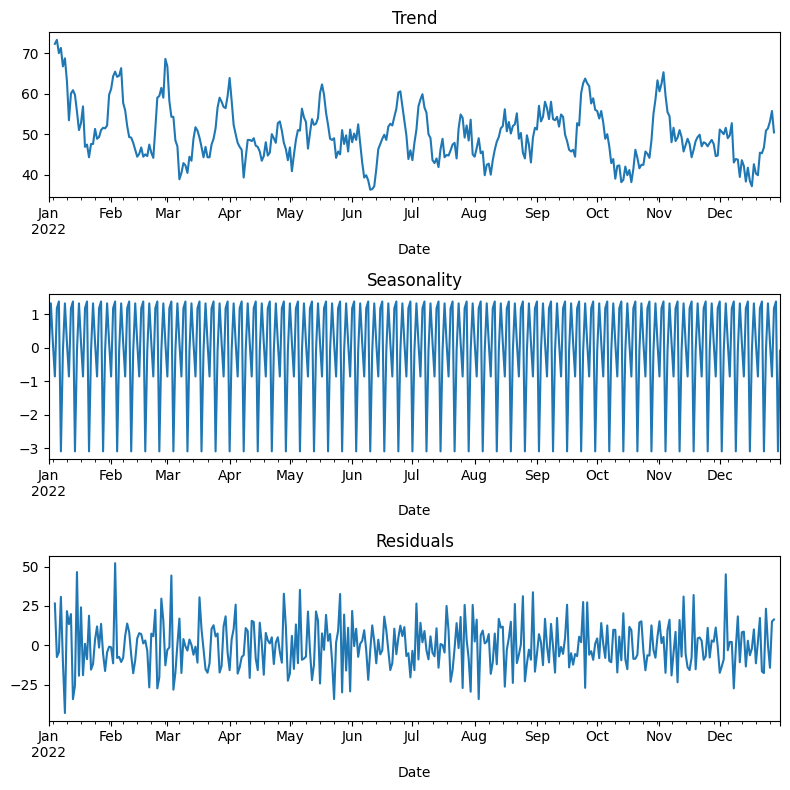

In [23]:
#digunakan untuk menghasilkan tiga subplot dalam satu gambar, masing-masing mewakili komponen utama dari analisis dekomposisi musiman pada data time series
decomposed = seasonal_decompose(regresi_data.set_index('Date'))

plt.figure(figsize = (8,8))

plt.subplot(311)
decomposed.trend.plot(ax = plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax = plt.gca())
plt.title('Residuals')

plt.tight_layout()

In [24]:
#untuk membagi data time series menjadi dua set: set pelatihan (train) dan set pengujian (test)
cut_off = round(regresi_data.shape[0]*0.8)
train_df = regresi_data[:cut_off]
test_df = regresi_data[cut_off:].reset_index(drop=True)
train_df.shape, test_df.shape

((292, 2), (73, 2))

In [25]:
train_df

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
287,2022-10-15,33
288,2022-10-16,26
289,2022-10-17,53
290,2022-10-18,47


In [26]:
test_df

,Date,Qty
0,2022-10-20,39
1,2022-10-21,35
2,2022-10-22,56
3,2022-10-23,59
4,2022-10-24,39
...,...,...
68,2022-12-27,70
69,2022-12-28,68
70,2022-12-29,42
71,2022-12-30,44


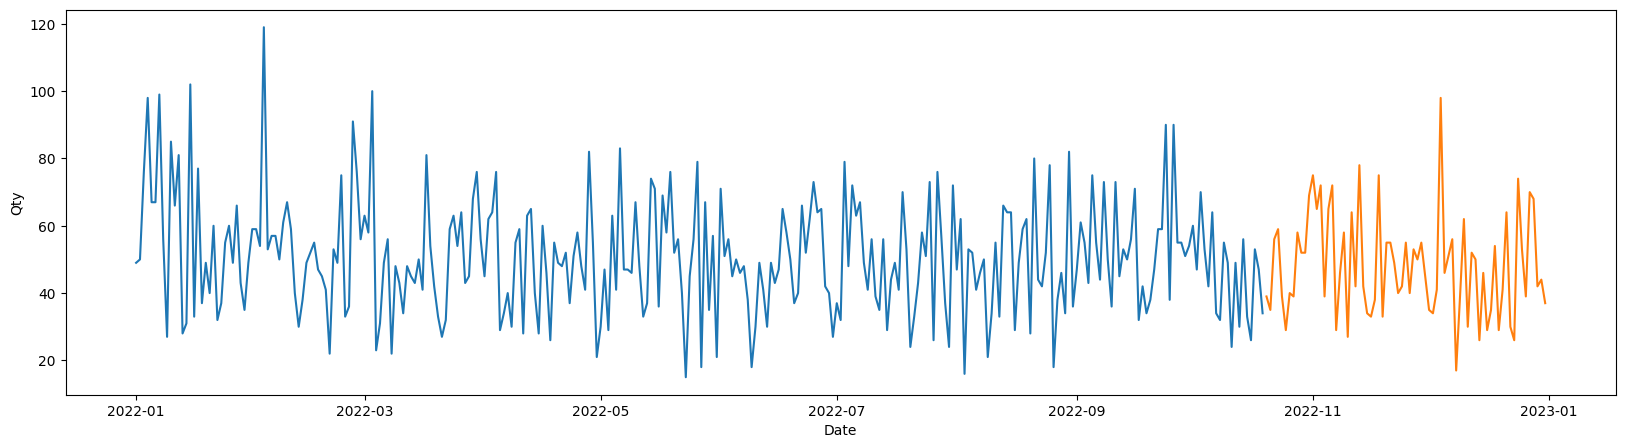

In [27]:
#membuat plot garis menggunakan library seaborn untuk memvisualisasikan data dalam set pelatihan (train) dan set pengujian (test) dari time series.
plt.figure(figsize=(20,5))
sns.lineplot(data=train_df, x=train_df['Date'], y=train_df['Qty']);
sns.lineplot(data=test_df, x=test_df['Date'], y=test_df['Qty']);

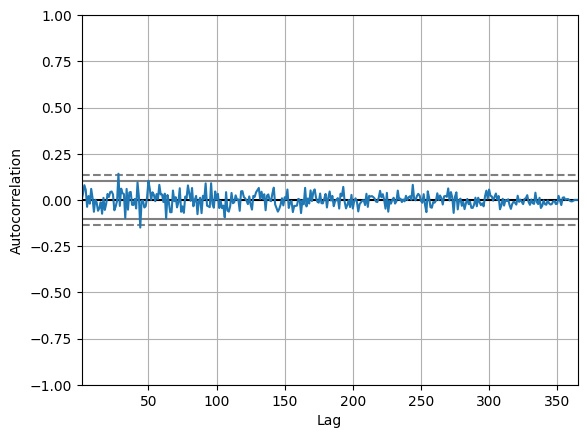

In [60]:
#mengilustrasikan seberapa berkorelasinya suatu variabel dengan dirinya sendiri pada pergeseran waktu yang berbeda (lag).
autocorrelation_plot(regresi_data['Qty']);

In [28]:
#untuk mengambil baris-baris dari dataframe customer_data di mana kolom 'Marital Status' memiliki nilai yang kosong
customer_data[customer_data['Marital Status'].isnull()]

,CustomerID,Age,Gender,Marital Status,Income,Longitude
9,10,34,1,NaN,4.0,NaN
415,416,27,1,NaN,3.0,NaN
442,443,33,1,NaN,9.0,NaN


In [29]:
#mengambil baris-baris dari dataframe merge_data di mana kolom 'Marital Status' memiliki nilai yang kosong
merge_data[merge_data['Marital Status'].isnull()]

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Longitude_x,Product Name,StoreName,GroupStore,Type,Latitude,Longitude_y
143,TR65931,443,2022-05-19,P1,8800,5,44000,12,33,1,NaN,9.0,NaN,Choco Bar,Prestasi Utama,Prestasi,General Trade,-2.0,NaN
175,TR92340,416,2022-03-14,P7,9400,6,56400,12,27,1,NaN,3.0,NaN,Coffee Candy,Prestasi Utama,Prestasi,General Trade,-2.0,NaN
295,TR28303,10,2022-12-30,P10,15000,4,60000,12,34,1,NaN,4.0,NaN,Cheese Stick,Prestasi Utama,Prestasi,General Trade,-2.0,NaN
387,TR84178,10,2022-04-25,P3,7500,1,7500,13,34,1,NaN,4.0,NaN,Crackers,Buana,Buana,General Trade,-1.0,NaN
458,TR78858,443,2022-09-22,P5,4200,5,21000,13,33,1,NaN,9.0,NaN,Thai Tea,Buana,Buana,General Trade,-1.0,NaN
502,TR51422,443,2022-02-09,P1,8800,8,70400,13,33,1,NaN,9.0,NaN,Choco Bar,Buana,Buana,General Trade,-1.0,NaN
528,TR43714,416,2022-05-01,P7,9400,2,18800,13,27,1,NaN,3.0,NaN,Coffee Candy,Buana,Buana,General Trade,-1.0,NaN
544,TR63307,443,2022-01-20,P7,9400,4,37600,13,33,1,NaN,9.0,NaN,Coffee Candy,Buana,Buana,General Trade,-1.0,NaN
545,TR6857,443,2022-01-06,P7,9400,5,47000,13,33,1,NaN,9.0,NaN,Coffee Candy,Buana,Buana,General Trade,-1.0,NaN
552,TR8136,10,2022-09-18,P7,9400,5,47000,13,34,1,NaN,4.0,NaN,Coffee Candy,Buana,Buana,General Trade,-1.0,NaN


In [30]:
#menghitung dan mengevaluasi kinerja model prediksi menggunakan metrik MAE dan RMSE dengan menggunakan contoh data aktual dan prediksi.
def rmse(y_actual, y_pred):
    mse = mean_squared_error(y_actual, y_pred)
    rmse_value = mse ** 0.5
    return rmse_value


def eval(y_actual, y_pred):
    mae_value = mean_absolute_error(y_actual, y_pred)
    rmse_value = rmse(y_actual, y_pred)
    print(f'Nilai MAE: {mae_value}')
    print(f'Nilai RMSE: {rmse_value}')

y_actual = [3, 5, 7, 9]
y_pred = [2.8, 5.2, 6.6, 9.3]

eval(y_actual, y_pred)

Nilai MAE: 0.27500000000000036
Nilai RMSE: 0.2872281323269018


# **Metode time series ARIMA**

In [32]:
#mencetak informasi tentang kolom-kolom dan beberapa baris pertama dari dataframe train_df dan test_df
print(train_df.columns)
print(test_df.columns)

print(train_df.head())
print(test_df.head())

Index(['Date', 'Qty'], dtype='object')
Index(['Date', 'Qty'], dtype='object')
        Date  Qty
0 2022-01-01   49
1 2022-01-02   50
2 2022-01-03   76
3 2022-01-04   98
4 2022-01-05   67
        Date  Qty
0 2022-10-20   39
1 2022-10-21   35
2 2022-10-22   56
3 2022-10-23   59
4 2022-10-24   39


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai MAE: 12.357079825645519
Nilai RMSE: 15.472386623448042


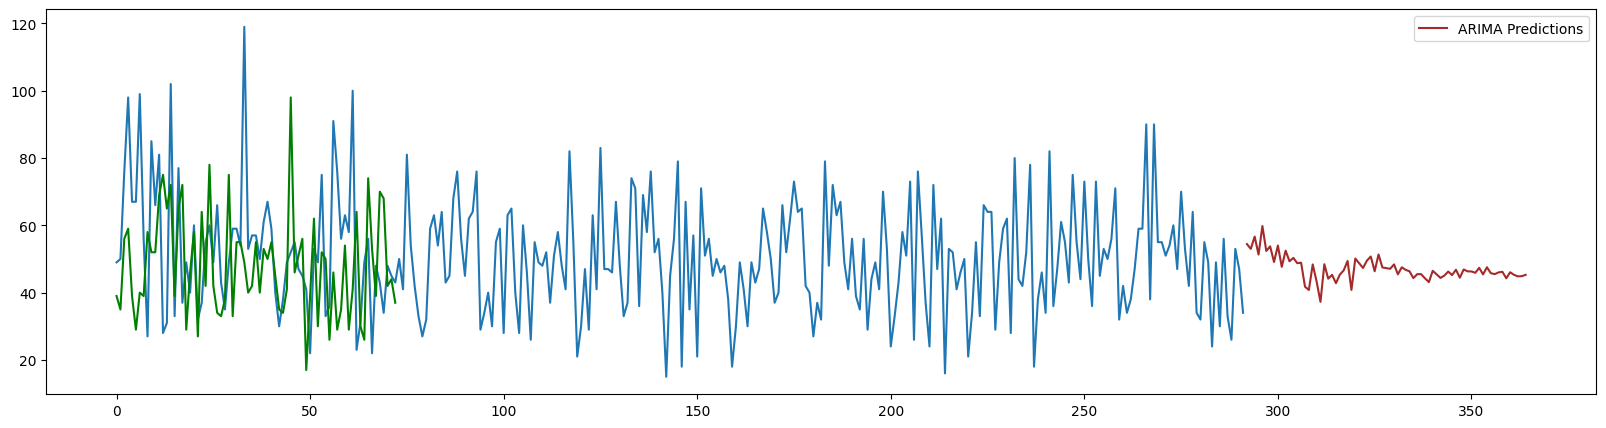

In [33]:
#membangun model ARIMA, membuat prediksi, mengevaluasi performa prediksi, dan membuat plot visualisasi dari hasil prediksi

y = train_df['Qty']

ARIMAmodel = ARIMA(y, order=(40, 2, 1))
ARIMAmodel_fit = ARIMAmodel.fit()

y_pred = ARIMAmodel_fit.get_forecast(steps=len(test_df))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMAmodel_fit.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
y_pred_out = y_pred_df['predictions']
eval(test_df['Qty'], y_pred_out)

plt.figure(figsize=(20, 5))
plt.plot(train_df['Qty'])
plt.plot(test_df['Qty'], color='green')
plt.plot(y_pred_out, color='brown', label='ARIMA Predictions')
plt.legend()
plt.show()

# **-- Model Machine Learning Clustering --**

In [34]:
#menampilkan lima baris pertama dari dataframe merge_data
merge_data.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Longitude_x,Product Name,StoreName,GroupStore,Type,Latitude,Longitude_y
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.0,NaN,Crackers,Prestasi Utama,Prestasi,General Trade,-2.0,NaN
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.0,NaN,Crackers,Prestasi Utama,Prestasi,General Trade,-2.0,NaN
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.0,NaN,Crackers,Prestasi Utama,Prestasi,General Trade,-2.0,NaN
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.0,NaN,Crackers,Prestasi Utama,Prestasi,General Trade,-2.0,NaN
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.0,NaN,Crackers,Prestasi Utama,Prestasi,General Trade,-2.0,NaN


In [35]:
#menghitung dan menampilkan matriks korelasi antar kolom-kolom dalam dataframe
merge_data.corr()

<ipython-input-35-f0b9e936349b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  merge_data.corr()


,CustomerID,Price,Qty,TotalAmount,StoreID,Age,Gender,Income,Longitude_x,Latitude,Longitude_y
CustomerID,1.000000,-0.016423,-0.009755,-0.024915,0.004129,-0.025952,-0.009947,0.007537,NaN,0.001060,NaN
Price,-0.016423,1.000000,-0.353640,0.440632,-0.032863,0.014693,0.010705,0.001439,NaN,-0.028502,NaN
Qty,-0.009755,-0.353640,1.000000,0.621129,0.014365,-0.027768,-0.010542,-0.029113,NaN,-0.002765,NaN
TotalAmount,-0.024915,0.440632,0.621129,1.000000,-0.010722,-0.016900,-0.008774,-0.025680,NaN,-0.028421,NaN
StoreID,0.004129,-0.032863,0.014365,-0.010722,1.000000,-0.003872,-0.000189,0.001189,NaN,0.488507,NaN
Age,-0.025952,0.014693,-0.027768,-0.016900,-0.003872,1.000000,-0.033183,0.485788,NaN,0.009051,NaN
Gender,-0.009947,0.010705,-0.010542,-0.008774,-0.000189,-0.033183,1.000000,-0.072268,NaN,-0.005635,NaN
Income,0.007537,0.001439,-0.029113,-0.025680,0.001189,0.485788,-0.072268,1.000000,NaN,0.014446,NaN
Longitude_x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Latitude,0.001060,-0.028502,-0.002765,-0.028421,0.488507,0.009051,-0.005635,0.014446,NaN,1.000000,NaN


In [37]:
#membuat fitur untuk clustering
cluster_df = merge_data.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'Qty' : 'sum',
    'TotalAmount' : 'sum'
}).reset_index()

In [38]:
cluster_df.head()

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['CustomerID'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_1, *['TransactionID'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_2, *['Qty'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_3, *['TotalAmount'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_4, *['CustomerID'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_5, *['TransactionID'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_6, *['Qty'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_7, *['TotalAmount'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_8, *[[['CustomerID', 'TransactionID'], ['TransactionID', 'Qty'], ['Qty', 'TotalAmount']]], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_9, *['CustomerID', 'TransactionID', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_10, *['CustomerID', 'Qty', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_11, *['CustomerID', 'TotalAmount', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_12, *['CustomerID', 'count()', None], **{})
chart

In [39]:
cluster_df

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600
...,...,...,...,...
442,443,16,59,485100
443,444,18,62,577700
444,445,18,68,587200
445,446,11,42,423300


In [40]:
#pra-pemrosesan data sebelum dilakukan analisis klasterisasi (clustering)
cluster_data = cluster_df.drop(columns = ['CustomerID'])

cluster_data_normalize = preprocessing.normalize(cluster_data)

In [41]:
#menampilkan data yang sudah dinormalisasi.
cluster_data_normalize

array([[2.72741856e-05, 9.62618317e-05, 9.99999995e-01],
       [3.31379043e-05, 1.45296965e-04, 9.99999989e-01],
       [3.36172117e-05, 1.25504257e-04, 9.99999992e-01],
       ...,
       [3.06539507e-05, 1.15803814e-04, 9.99999993e-01],
       [2.59862980e-05, 9.92204105e-05, 9.99999995e-01],
       [2.95925334e-05, 9.56066465e-05, 9.99999995e-01]])

In [61]:
#algoritma K-Means untuk melakukan analisis klasterisasi pada data yang telah dinormalisasi.
K = range(2,8)
fits = []
score = []

for k in K:
  model = KMeans(n_clusters = k, random_state = 0, n_init = 'auto').fit(cluster_data_normalize)
  fits.append(model)
  score.append(silhouette_score(cluster_data_normalize, model.labels_, metric = 'euclidean'))

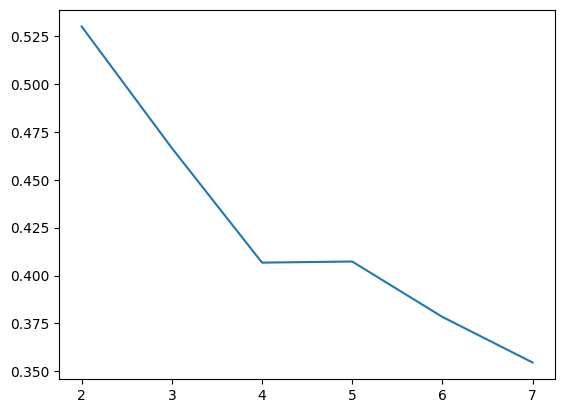

In [43]:
#memvisualisasikan bagaimana nilai silhouette score berubah seiring dengan jumlah klaster yang berbeda
sns.lineplot(x=K, y=score);

In [44]:
fits[1]

KMeans(n_clusters=3, n_init='auto', random_state=0)

In [45]:
#menambahkan kolom 'cluster_label' ke dalam dataframe cluster_df yang berisi label klaster hasil dari analisis K-Means
cluster_df['cluster_label'] = fits[2].labels_

In [47]:
#melakukan agregasi statistik pada dataframe cluster_df
cluster_df.groupby('cluster_label').agg({
    'CustomerID': 'count',
    'TransactionID' : 'mean',
    'Qty' : 'mean'
})

,CustomerID,TransactionID,Qty
cluster_label,,,
0,128,11.601562,40.007812
1,28,9.250000,35.142857
2,156,11.628205,42.775641
3,135,10.829630,40.874074


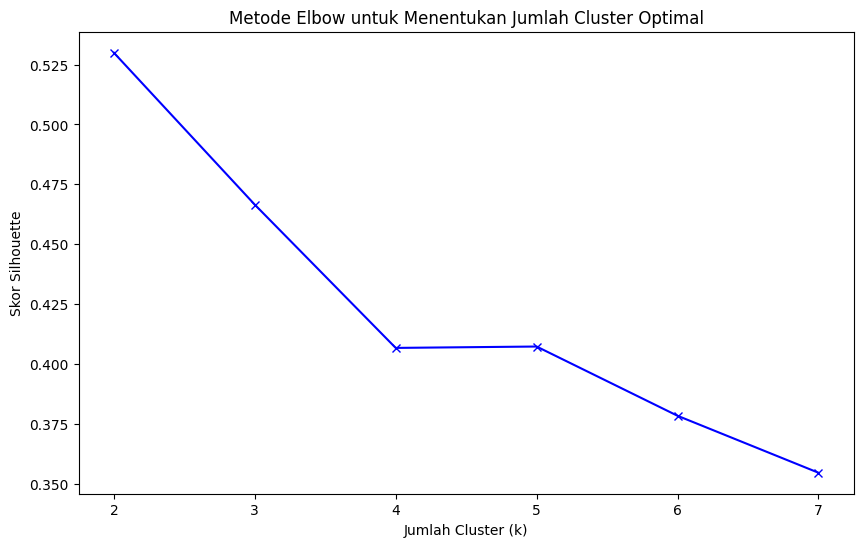

In [48]:
# Memvisualisasikan hasil siluet untuk menentukan jumlah cluster yang optimal
plt.figure(figsize=(10, 6))
plt.plot(K, score, 'bx-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Skor Silhouette')
plt.title('Metode Elbow untuk Menentukan Jumlah Cluster Optimal')
plt.show()

In [49]:
# Pilih jumlah cluster berdasarkan hasil visualisasi siluet
selected_k = 3
selected_model = fits[selected_k - 2]  # Indeks array dimulai dari 0


In [50]:
# Tambahkan informasi klaster ke dalam DataFrame cluster_df
cluster_df['cluster_label'] = selected_model.labels_

In [52]:
#analisis klasterisasi
cluster_analysis = cluster_df.groupby('cluster_label').agg({
    'CustomerID': 'count',
    'TransactionID': 'mean',
    'Qty': 'mean',
    'TotalAmount': 'mean'
})

In [53]:
# Memberikan rekomendasi berdasarkan analisis klaster
for cluster_label, data in cluster_analysis.iterrows():
    print(f"Cluster {cluster_label}:")
    print(f"Jumlah Pelanggan: {data['CustomerID']}")
    print(f"Rata-rata Transaksi per Pelanggan: {data['TransactionID']:.2f}")
    print(f"Rata-rata Kuantitas Produk per Pelanggan: {data['Qty']:.2f}")
    print(f"Rata-rata Total Pembelian per Pelanggan: {data['TotalAmount']:.2f}")
    print("\n")

Cluster 0:
Jumlah Pelanggan: 205.0
Rata-rata Transaksi per Pelanggan: 11.65
Rata-rata Kuantitas Produk per Pelanggan: 40.88
Rata-rata Total Pembelian per Pelanggan: 409866.83


Cluster 1:
Jumlah Pelanggan: 61.0
Rata-rata Transaksi per Pelanggan: 10.34
Rata-rata Kuantitas Produk per Pelanggan: 39.23
Rata-rata Total Pembelian per Pelanggan: 268652.46


Cluster 2:
Jumlah Pelanggan: 181.0
Rata-rata Transaksi per Pelanggan: 11.05
Rata-rata Kuantitas Produk per Pelanggan: 41.56
Rata-rata Total Pembelian per Pelanggan: 340511.05




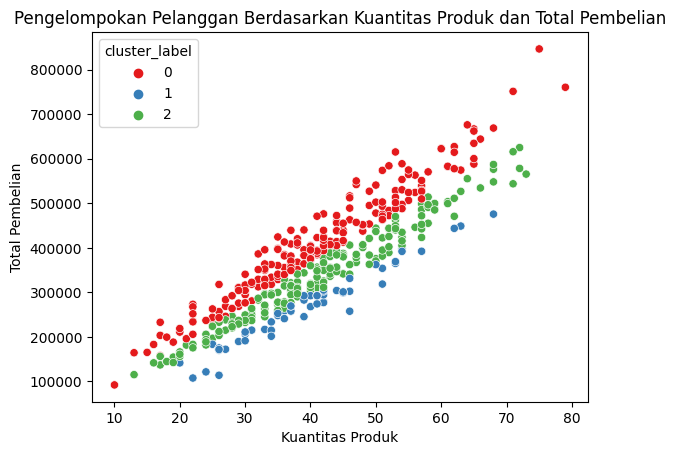

In [54]:
# Visualisasi klaster dengan scatter plot
sns.scatterplot(data=cluster_df, x='Qty', y='TotalAmount', hue='cluster_label', palette='Set1')
plt.xlabel('Kuantitas Produk')
plt.ylabel('Total Pembelian')
plt.title('Pengelompokan Pelanggan Berdasarkan Kuantitas Produk dan Total Pembelian')
plt.show()